# Coursera Capstone Project

### Anand Konji

Now that you have been equipped with the skills and the tools to use location data to explore a geographical location, over the course of two weeks, you will have the opportunity to be as creative as you want and come up with an idea to leverage the Foursquare location data to explore or compare neighborhoods or cities of your choice or to come up with a problem that you can use the Foursquare location data to solve. If you cannot think of an idea or a problem, here are some ideas to get you started:

In Module 3, we explored New York City and the city of Toronto and segmented and clustered their neighborhoods. Both cities are very diverse and are the financial capitals of their respective countries. One interesting idea would be to compare the neighborhoods of the two cities and determine how similar or dissimilar they are. Is New York City more like Toronto or Paris or some other multicultural city? I will leave it to you to refine this idea.
In a city of your choice, if someone is looking to open a restaurant, where would you recommend that they open it? Similarly, if a contractor is trying to start their own business, where would you recommend that they setup their office?
These are just a couple of many ideas and problems that can be solved using location data in addition to other datasets. No matter what you decide to do, make sure to provide sufficient justification of why you think what you want to do or solve is important and why would a client or a group of people be interested in your project.

Review criterialess 
This capstone project will be graded by your peers. This capstone project is worth 70% of your total grade. The project will be completed over the course of 2 weeks. Week 1 submissions will be worth 30% whereas week 2 submissions will be worth 40% of your total grade.

For this week, you will required to submit the following:

A description of the problem and a discussion of the background. (15 marks)
A description of the data and how it will be used to solve the problem. (15 marks)
For the second week, the final deliverables of the project will be:

A link to your Notebook on your Github repository, showing your code. (15 marks)
A full report consisting of all of the following components (15 marks):
Introduction where you discuss the business problem and who would be interested in this project.
Data where you describe the data that will be used to solve the problem and the source of the data.
Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.
Results section where you discuss the results.
Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.
Conclusion section where you conclude the report.
3. Your choice of a presentation or blogpost. (10 marks)  
------------------------

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## 1.	Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening an **Italian restaurant** in **Bangalore**, India.

Since there are lots of restaurants in Bangalore we will try to detect **locations that are not already crowded with restaurants**. We are also particularly interested in **areas with no Italian restaurants in vicinity**. We would also prefer locations **as close to city center as possible**, assuming that first two conditions are met.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## 2.	Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* number of and distance to Italian restaurants in the neighborhood, if any
* distance of neighborhood from city center

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **reverse geocoding**
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of Bangalore center will be obtained using **geocoding** of well known Bangalore location (Koramangala)

### Neighborhood Candidates

Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods. We will create a grid of cells covering our area of interest which is aprox. 10x10 killometers centered around Bangalore city center.

Let's first find the latitude & longitude of Bangalore city center.

#### install the packages required, if not done already

In [1]:
# install the packages required, if not done already
!pip install beautifulsoup4
!pip install lxml
!pip install geocoder
!pip install geopy
!pip install folium
print("Installed required packages !!!")

Installed required packages !!!


#### import the required libraries

In [2]:
# import the libraries
import pandas as pd
import requests as rqt
from bs4 import BeautifulSoup as bs
import numpy as np
import geocoder as gc

import folium
import requests 
import json 
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from geopy.geocoders import Nominatim 

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.cm as cm
import matplotlib.colors as colors


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("Imported required stuffs!")

Imported required stuffs!


#### Scraping Wikipedia page and creating a Dataframe and Transforming the data on Wiki page into pandas dataframe.

Using BeautifulSoup Scraping List of Postal Codes of Given Wikipedia/other source Page 

In [3]:
url = "http://pincode.india-server.com/cities/bengaluru/"
extractData = rqt.get(url).text
wikiData = bs(extractData, 'lxml')

In [4]:
#wikiData

Converting content of PostalCode HTML table as dataframe

In [4]:
columnNames = ['Postalcode','Town','Neighborhood']
bangalore = pd.DataFrame(columns = columnNames)

table = wikiData.find('table', class_='pincode-tbl')

In [6]:
#table

In [5]:
# parsing data and pushing to table rows
SrNo = 0
Neighborhood = 0
town='Bangalore'
OffType = 0
PinCode = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            SrNo = td.text.strip('\n')
            i = i + 1
        elif i == 1:
            Neighborhood = td.text.strip('\n')
            i = i + 1
        elif i == 2:
            OffType = td.text.strip('\n')
            i = i + 1
        elif i == 3: 
            PinCode = td.text.strip('\n').replace(']','')
    #bangalore = bangalore.append({'S.No.': SrNo,'Post office': PoOff,'Office type': OffType, 'Pincode': PinCode},ignore_index=True)
    bangalore = bangalore.append({'Postalcode': PinCode,'Town': town,'Neighborhood': Neighborhood},ignore_index=True)

In [6]:
bangalore.head()

,Postalcode,Town,Neighborhood
0,0,Bangalore,0
1,Pincode,Bangalore,Post office
2,560063,Bangalore,A F Station Yelahanka
3,560107,Bangalore,Achitnagar
4,561101,Bangalore,Adarangi


Data cleansing

In [6]:
# clean dataframe 
bangalore = bangalore[bangalore.Neighborhood!='Not assigned']
bangalore = bangalore[bangalore.Neighborhood!= 0]
bangalore = bangalore[bangalore.Neighborhood!='Post office']
bangalore.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,bangalore.shape[0]):
    if bangalore.iloc[i][2] == 'Not assigned':
        bangalore.iloc[i][2] = bangalore.iloc[i][1]
        i = i+1

In [7]:
df = bangalore.groupby(['Postalcode','Town'])['Neighborhood'].apply(', '.join).reset_index()

In [8]:
df.head()

,Postalcode,Town,Neighborhood
0,560001,Bangalore,"Bangalore Bazaar , Bangalore G.P.O., CMM Court..."
1,560002,Bangalore,"Bangalore City , Bangalore Corporation Building"
2,560003,Bangalore,"Malleswaram , Palace Guttahalli , Swimming Poo..."
3,560004,Bangalore,"Basavanagudi , Mavalli , Pampamahakavi Road , ..."
4,560005,Bangalore,Fraser Town


In [9]:
df.describe()

,Postalcode,Town,Neighborhood
count,131,131,131
unique,131,1,131
top,560049,Bangalore,"Gayathrinagar , Srirampuram"
freq,1,131,1


Data Cleaning | Drop None rows of df and row which contains 'Not assigned' value | All "Not assigned" will be replace to 'NaN'

In [10]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Town != empty) & (df.Neighborhood != empty)]

In [11]:
df.head()

,Postalcode,Town,Neighborhood
0,560001,Bangalore,"Bangalore Bazaar , Bangalore G.P.O., CMM Court..."
1,560002,Bangalore,"Bangalore City , Bangalore Corporation Building"
2,560003,Bangalore,"Malleswaram , Palace Guttahalli , Swimming Poo..."
3,560004,Bangalore,"Basavanagudi , Mavalli , Pampamahakavi Road , ..."
4,560005,Bangalore,Fraser Town


In [12]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Town'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [13]:
df_2.describe()

,Postalcode,Town,Neighborhood
count,131,131,131
unique,131,1,131
top,560049,Bangalore,"Gayathrinagar , Srirampuram"
freq,1,131,1


In [14]:
print(df_2.shape)
df_2.head()

(131, 3)


,Postalcode,Town,Neighborhood
0,560001,Bangalore,"Bangalore Bazaar , Bangalore G.P.O., CMM Court..."
1,560002,Bangalore,"Bangalore City , Bangalore Corporation Building"
2,560003,Bangalore,"Malleswaram , Palace Guttahalli , Swimming Poo..."
3,560004,Bangalore,"Basavanagudi , Mavalli , Pampamahakavi Road , ..."
4,560005,Bangalore,Fraser Town


In [17]:
#df_2.to_csv('bangalore.csv', index=False) 

#### Adding Latitude and Longitude Co-ordinates to the DataFrame

Reading the bangalore.csv which created on Part 1 Notebook

In [18]:
#df = pd.read_csv('bangalore.csv')
df.head()

,Postalcode,Town,Neighborhood
0,560001,Bangalore,"Bangalore Bazaar , Bangalore G.P.O., CMM Court..."
1,560002,Bangalore,"Bangalore City , Bangalore Corporation Building"
2,560003,Bangalore,"Malleswaram , Palace Guttahalli , Swimming Poo..."
3,560004,Bangalore,"Basavanagudi , Mavalli , Pampamahakavi Road , ..."
4,560005,Bangalore,Fraser Town


In [15]:
print(df.shape)
#df.describe()

(131, 3)


In [16]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = gc.arcgis('{}, Bangalore, Karnataka'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong(560034)

[12.931355000000053, 77.63397875900006]

In [17]:
# Retrieving Postal Code Co-ordinates
postal_codes = df['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [18]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

In [24]:
#df[df.Postalcode == 560034]

In [19]:
df.head()

,Postalcode,Town,Neighborhood,Latitude,Longitude
0,560001,Bangalore,"Bangalore Bazaar , Bangalore G.P.O., CMM Court...",12.979185,77.606623
1,560002,Bangalore,"Bangalore City , Bangalore Corporation Building",12.964070,77.577647
2,560003,Bangalore,"Malleswaram , Palace Guttahalli , Swimming Poo...",13.003656,77.569745
3,560004,Bangalore,"Basavanagudi , Mavalli , Pampamahakavi Road , ...",12.945664,77.575075
4,560005,Bangalore,Fraser Town,12.998115,77.620842


In [26]:
#df.to_csv('bangalore_lalo.csv',index=False)

In [27]:
#df.head()

## 3.	Methodology  


In [20]:
#df = pd.read_csv('bangalore_lalo.csv')
print(df.shape)
df.head()

(131, 5)


,Postalcode,Town,Neighborhood,Latitude,Longitude
0,560001,Bangalore,"Bangalore Bazaar , Bangalore G.P.O., CMM Court...",12.979185,77.606623
1,560002,Bangalore,"Bangalore City , Bangalore Corporation Building",12.964070,77.577647
2,560003,Bangalore,"Malleswaram , Palace Guttahalli , Swimming Poo...",13.003656,77.569745
3,560004,Bangalore,"Basavanagudi , Mavalli , Pampamahakavi Road , ...",12.945664,77.575075
4,560005,Bangalore,Fraser Town,12.998115,77.620842


##### Getting the coordinates of Bangalore City

In [21]:
address = 'Bangalore, India'
geolocator = Nominatim(user_agent="bangalore_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangalore India are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangalore India are 12.9791198, 77.5912997.


##### Creating a map of Bangalore City with neighborhoods superimposed on top

In [22]:
# create map of Bangalore using latitude and longitude values
map_bangalore = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, town, neighborhood in zip(df['Latitude'], df['Longitude'], df['Town'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, town)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bangalore)
    
map_bangalore

 ##### Utilizing the Foursquare API to explore the neighborhoods and segment them

Defining Foursquare Credentials and Version

In [23]:
# Foursquare API
CLIENT_ID = '2A51C3ZVYHCBBJ3G1JTWNBUPP3UOQHPU015V3DO4LY2PIPLB' # Put Your Client Id
CLIENT_SECRET = '1NBYJR1HFLDNDNJACE0C4EPYURV4ACOFXB2IHSCROAHN41KW' # Put You Client Secret 
VERSION = '20200508'
CATEGORYID='4d4b7105d754a06374d81259' # for food category from doc https://developer.foursquare.com/docs/build-with-foursquare/categories/
#CATEGORYID='4bf58dd8d48988d110941735' # for Italian category
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: Hidden')
print('CLIENT_SECRET: Hidden')

Your credentails:
CLIENT_ID: Hidden
CLIENT_SECRET: Hidden


##### Creating a dataframe with all the venues information provided by foursquare for the given latitude and longitude values


In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CATEGORYID,CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        #print(url)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([( name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    print('Done !!!')
    return(nearby_venues)        


Using the above function on each neighborhood and create a new dataframe called bangalore_venues

In [25]:
#df = bangalore_data
bangalore_venues = getNearbyVenues(names=df['Neighborhood'], latitudes=df['Latitude'],longitudes=df['Longitude'])


Bangalore Bazaar , Bangalore G.P.O., CMM Court Complex , Dr. Ambedkar Veedhi , HighCourt , Legislators Home , Mahatma Gandhi Road , Rajbhavan  , Vasanthanagar , Vidhana Soudha 
Bangalore City , Bangalore Corporation Building 
Malleswaram , Palace Guttahalli , Swimming Pool Extn , Vyalikaval Extn 
Basavanagudi , Mavalli , Pampamahakavi Road , Thyagarajnagar 
Fraser Town 
J.C.Nagar , Training Command IAF 
Agram , Air Force Hospital 
H.A.L II Stage , Hulsur Bazaar 
Bangalore Dist Offices Bldg , K. G. Road 
Industrial Estate  , Rajajinagar , Rajajinagar IVth Block 
Jayangar III Block , Madhavan Park 
Science Institute 
Jalahalli 
Jalahalli East 
Jalahalli West 
Doorvaninagar , Krishnarajapuram R S , Ramamurthy Nagar 
NAL , Vimanapura 
Chamrajpet  
Gaviopuram Extension 
Seshadripuram 
Gayathrinagar , Srirampuram 
Yeshwanthpur Bazar , Yeswanthpura 
Magadi Road 
Anandnagar  , H.A. Farm , Hebbal Kempapura 
Bangalore Sub Foreign Post , CMP Centre And School , Museum Road , Richmond Town 
Deepan

In [26]:
print(bangalore_venues.shape)
bangalore_venues.head()

(718, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Bangalore Bazaar , Bangalore G.P.O., CMM Court...",12.979185,77.606623,Peppa Zzing,12.979700,77.605907,Burger Joint
1,"Bangalore Bazaar , Bangalore G.P.O., CMM Court...",12.979185,77.606623,Samarkand,12.980616,77.604668,Afghan Restaurant
2,"Bangalore Bazaar , Bangalore G.P.O., CMM Court...",12.979185,77.606623,Coast 2 Coast,12.975305,77.605625,Indian Restaurant
3,"Bangalore Bazaar , Bangalore G.P.O., CMM Court...",12.979185,77.606623,Krispy Kreme,12.982630,77.607027,Donut Shop
4,"Bangalore Bazaar , Bangalore G.P.O., CMM Court...",12.979185,77.606623,Shiv Sagar,12.981879,77.608322,Indian Restaurant


In [36]:
#bangalore_venues.to_csv('bangalore_venues1.csv')

In [27]:
# Number of venues for each nrighborhood
bangalore_venues.groupby('Neighborhood')
print('There are {} uniques categories.'.format(len(bangalore_venues['Venue Category'].unique())))

There are 58 uniques categories.


### Extracting only restaurants from venue category list and creating a dataframe "bangalore_restaurants"

In [28]:
bangalore_restaurants = bangalore_venues[bangalore_venues['Venue Category'].str.contains("Restaurant")]

In [39]:
print('There are {} unique categories or cusines available in Bangalore.'.format(len(bangalore_restaurants['Venue Category'].unique())))

There are 31 unique categories or cusines available in Bangalore.


## 4. Analysis of each neighborhood

In [29]:
# one hot encoding
bangalore_onehot = pd.get_dummies(bangalore_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bangalore_onehot['Neighborhood'] = bangalore_restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bangalore_onehot.columns[-1]] + list(bangalore_onehot.columns[:-1])
bangalore_onehot = bangalore_onehot[fixed_columns]

bangalore_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Chinese Restaurant,Dumpling Restaurant,Falafel Restaurant,Fast Food Restaurant,Hyderabadi Restaurant,Indian Chinese Restaurant,Indian Restaurant,Italian Restaurant,Karnataka Restaurant,Kerala Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Multicuisine Indian Restaurant,North Indian Restaurant,Punjabi Restaurant,Rajasthani Restaurant,Restaurant,Seafood Restaurant,South Indian Restaurant,Thai Restaurant,Tibetan Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
1,"Bangalore Bazaar , Bangalore G.P.O., CMM Court...",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Bangalore Bazaar , Bangalore G.P.O., CMM Court...",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Bangalore Bazaar , Bangalore G.P.O., CMM Court...",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,"Bangalore Bazaar , Bangalore G.P.O., CMM Court...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7,"Bangalore Bazaar , Bangalore G.P.O., CMM Court...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [30]:
print('There are {} restaurants in Bangalore with {} different style of cuisines.'.format(bangalore_onehot.shape[0],(bangalore_onehot.shape[1]-1)))

There are 455 restaurants in Bangalore with 31 different style of cuisines.


##### Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category/restaurants

In [31]:
bangalore_grouped = bangalore_onehot.groupby('Neighborhood').mean().reset_index()
bangalore_grouped

,Neighborhood,Afghan Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Chinese Restaurant,Dumpling Restaurant,Falafel Restaurant,Fast Food Restaurant,Hyderabadi Restaurant,Indian Chinese Restaurant,Indian Restaurant,Italian Restaurant,Karnataka Restaurant,Kerala Restaurant,Korean Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Multicuisine Indian Restaurant,North Indian Restaurant,Punjabi Restaurant,Rajasthani Restaurant,Restaurant,Seafood Restaurant,South Indian Restaurant,Thai Restaurant,Tibetan Restaurant,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Achitnagar,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.0,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,"Adarangi , Hulikal , Kudur , Marasandra , Maya...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.125000,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,Adugodi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.166667,0.000000,0.000000,0.333333,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,"Agara , Koramangala I Block , Koramangala , St...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.111111,0.111111,0.000000,0.444444,0.111111,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.111111
4,Ajjanahalli,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.125000,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
5,"Amruthahalli , Byatarayanapura , Kodigehalli ,...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.166667,0.000000,0.000000,0.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
6,"Anandnagar , H.A. Farm , Hebbal Kempapura",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,"Arabic College , Venkateshapura",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8,"Arebommnahalli , Baragenahalli , Billanakote ,...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.500000,0.000000
9,"Ashoknagar , Banashankari , Dasarahalli(Srina...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


In [32]:
bangalore_grouped.shape

(81, 32)

##### Top 3 restaurants for each Neighborhood based on cuisine

In [33]:
num_top_venues = 5
for neighbor in bangalore_grouped['Neighborhood']:
    print("----"+neighbor+"----")
    temp = bangalore_grouped[bangalore_grouped['Neighborhood'] == neighbor].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print("-----------------")
    print('\n')

----Achitnagar ----
                           venue  freq
0               Asian Restaurant   0.5
1           Fast Food Restaurant   0.5
2              Afghan Restaurant   0.0
3      Middle Eastern Restaurant   0.0
4  Vegetarian / Vegan Restaurant   0.0
-----------------


----Adarangi , Hulikal , Kudur , Marasandra , Mayasandra , Sirigiripura , Sugganahalli ----
                       venue  freq
0          Indian Restaurant  0.75
1       Fast Food Restaurant  0.12
2      Rajasthani Restaurant  0.12
3          Afghan Restaurant  0.00
4  Middle Eastern Restaurant  0.00
-----------------


----Adugodi ----
                  venue  freq
0            Restaurant  0.33
1     Indian Restaurant  0.33
2  Karnataka Restaurant  0.17
3  Fast Food Restaurant  0.17
4     Afghan Restaurant  0.00
-----------------


----Agara , Koramangala I Block , Koramangala , St. John Medical College ----
                   venue  freq
0      Indian Restaurant  0.44
1  Vietnamese Restaurant  0.11
2      Kerala Re

##### Creating a new dataframe with the above results for each neighborhood

In [34]:
# A function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:
#Creating a new dataframe and displaying the top 10 restaurants based on occurance and cuisine for each neighborhood
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bangalore_grouped['Neighborhood']

for ind in np.arange(bangalore_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangalore_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Achitnagar,Asian Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Korean Restaurant,American Restaurant,Andhra Restaurant,Chinese Restaurant,Dumpling Restaurant,Falafel Restaurant,Hyderabadi Restaurant
1,"Adarangi , Hulikal , Kudur , Marasandra , Maya...",Indian Restaurant,Rajasthani Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Korean Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Chinese Restaurant,Dumpling Restaurant
2,Adugodi,Restaurant,Indian Restaurant,Fast Food Restaurant,Karnataka Restaurant,Vietnamese Restaurant,Korean Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Chinese Restaurant
3,"Agara , Koramangala I Block , Koramangala , St...",Indian Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Hyderabadi Restaurant,Italian Restaurant,Kerala Restaurant,Korean Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant
4,Ajjanahalli,Indian Restaurant,Rajasthani Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Korean Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Chinese Restaurant,Dumpling Restaurant


#### Custering Neighborhoods using K-means

##### Finding the best k

In [36]:
# Creating new dataframe to determine best k value by dropping first column
bangalore_clustering_testing = bangalore_grouped.drop('Neighborhood', 1)

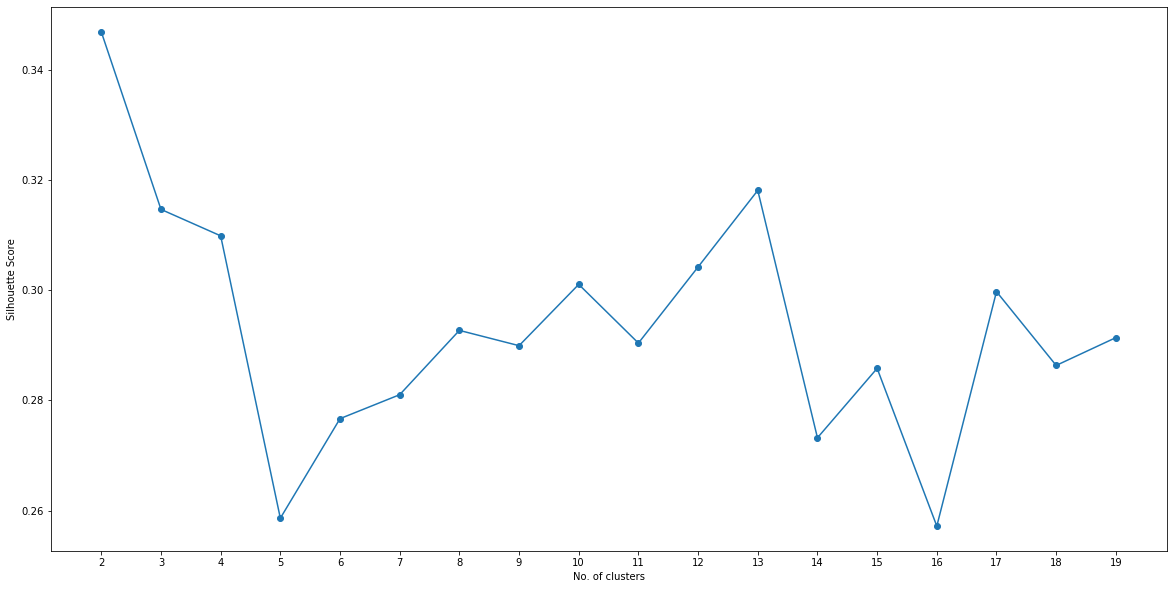

In [37]:
def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()
    
indices = []
scores = []
max_range = 20

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    lct = bangalore_clustering_testing
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(lct)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(lct, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)
    
# Silhouette method
plot(max_range, scores, "No. of clusters", "Silhouette Score")


##### From the graph the optimal number is found out to be considered for our clustering

In [38]:
opt = np.argmax(scores) + 2 # Finds the optimal value
opt
# visually also we can see peak value is at opt number

2

In [75]:
#Elbow Method for finding the optimal number of clusters
#set.seed(123)
# Compute and plot wss for k = 2 to k = 15.
#k.max <- 15
#data <- bangalore_clustering_testing
#wss <- sapply(1:k.max, 
#              function(k){kmeans(data, k, nstart=50,iter.max = 15 )$tot.withinss})
#wss
#plot(1:k.max, wss,
#     type="b", pch = 19, frame = FALSE, 
#     xlab="Number of clusters K",
#     ylab="Total within-clusters sum of squares")

In [39]:
# set number of clusters
kclusters = opt

bangalore_grouped_clustering = bangalore_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(bangalore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_[0:10])
print(len(kmeans.labels_))

[1 0 1 0 0 0 0 1 1 0]
81


#### Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [40]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bangalore_merged = bangalore_restaurants

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bangalore_merged = bangalore_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

bangalore_merged.fillna(0)
bangalore_merged.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Bangalore Bazaar , Bangalore G.P.O., CMM Court...",12.979185,77.606623,Samarkand,12.980616,77.604668,Afghan Restaurant,0,Indian Restaurant,Fast Food Restaurant,American Restaurant,Afghan Restaurant,Multicuisine Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Modern European Restaurant,Italian Restaurant,Indian Chinese Restaurant
2,"Bangalore Bazaar , Bangalore G.P.O., CMM Court...",12.979185,77.606623,Coast 2 Coast,12.975305,77.605625,Indian Restaurant,0,Indian Restaurant,Fast Food Restaurant,American Restaurant,Afghan Restaurant,Multicuisine Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Modern European Restaurant,Italian Restaurant,Indian Chinese Restaurant
4,"Bangalore Bazaar , Bangalore G.P.O., CMM Court...",12.979185,77.606623,Shiv Sagar,12.981879,77.608322,Indian Restaurant,0,Indian Restaurant,Fast Food Restaurant,American Restaurant,Afghan Restaurant,Multicuisine Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Modern European Restaurant,Italian Restaurant,Indian Chinese Restaurant
5,"Bangalore Bazaar , Bangalore G.P.O., CMM Court...",12.979185,77.606623,MTR 1924 commercial street,12.982062,77.607314,South Indian Restaurant,0,Indian Restaurant,Fast Food Restaurant,American Restaurant,Afghan Restaurant,Multicuisine Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Modern European Restaurant,Italian Restaurant,Indian Chinese Restaurant
7,"Bangalore Bazaar , Bangalore G.P.O., CMM Court...",12.979185,77.606623,Ebony,12.975180,77.605090,Modern European Restaurant,0,Indian Restaurant,Fast Food Restaurant,American Restaurant,Afghan Restaurant,Multicuisine Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Modern European Restaurant,Italian Restaurant,Indian Chinese Restaurant


##### Number of venues belonging to each cluster

In [41]:
bangalore_merged['Cluster Labels'].value_counts()

0    365
1     90
Name: Cluster Labels, dtype: int64

#### Creating map for each cluster for better visualization

In [42]:
# create map
map_clusters = folium.Map(location=[latitude,longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, vc in zip(bangalore_merged['Venue Latitude'], bangalore_merged['Venue Longitude'], bangalore_merged['Venue'], bangalore_merged['Cluster Labels'], bangalore_merged['Venue Category']):
    label = folium.Popup(str(poi) +' (' +str(vc) + ') ['+ str(cluster)+']', parse_html=True)    
    folium.CircleMarker([lat, lon], radius=5, popup=label, color=rainbow[cluster-1], fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.7).add_to(map_clusters)
    #count += 1
map_clusters

#### Final analysis of each cluster  

Now, examining each cluster and determining the discriminating restaurants that distinguish each cluster. 
Based on the restaurants, we can then assign a name to each cluster.

##### Cluster 1

In [43]:
c1 = bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 0, bangalore_merged.columns[[0]+list(range(8, bangalore_merged.shape[1]))]]
c1.drop_duplicates()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Bangalore Bazaar , Bangalore G.P.O., CMM Court...",Indian Restaurant,Fast Food Restaurant,American Restaurant,Afghan Restaurant,Multicuisine Indian Restaurant,South Indian Restaurant,Chinese Restaurant,Modern European Restaurant,Italian Restaurant,Indian Chinese Restaurant
37,"Bangalore City , Bangalore Corporation Building",Indian Restaurant,South Indian Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Kerala Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Chinese Restaurant,Dumpling Restaurant
55,"Basavanagudi , Mavalli , Pampamahakavi Road , ...",Indian Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Asian Restaurant,Restaurant,Korean Restaurant,American Restaurant,Andhra Restaurant,Chinese Restaurant,Dumpling Restaurant
80,Fraser Town,Indian Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Vietnamese Restaurant,Korean Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Dumpling Restaurant,Falafel Restaurant
90,"J.C.Nagar , Training Command IAF",Asian Restaurant,Indian Restaurant,Italian Restaurant,Vietnamese Restaurant,Korean Restaurant,American Restaurant,Andhra Restaurant,Chinese Restaurant,Dumpling Restaurant,Falafel Restaurant
96,"Bangalore Dist Offices Bldg , K. G. Road",Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,South Indian Restaurant,Seafood Restaurant,Vietnamese Restaurant,Italian Restaurant,Indian Chinese Restaurant,Hyderabadi Restaurant
119,"Industrial Estate , Rajajinagar , Rajajinagar...",Indian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Kerala Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Chinese Restaurant
136,Science Institute,Indian Restaurant,Restaurant,Vietnamese Restaurant,Korean Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Chinese Restaurant,Dumpling Restaurant,Falafel Restaurant
139,Jalahalli,Indian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Korean Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Chinese Restaurant,Dumpling Restaurant,Falafel Restaurant
142,"Doorvaninagar , Krishnarajapuram R S , Ramamur...",Indian Restaurant,Vietnamese Restaurant,Korean Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Chinese Restaurant,Dumpling Restaurant,Falafel Restaurant,Fast Food Restaurant


In [44]:
c1_table = bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 0, bangalore_merged.columns[[0]+[3]+[4]+[5]+list(range(8, bangalore_merged.shape[1]))]]

# create map
map_clusters = folium.Map(location=[ latitude,longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c1_table['Venue Latitude'], c1_table['Venue Longitude'], c1_table['Venue'], c1_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
    #count += 1
map_clusters

##### Cluster 2

In [45]:
c2 = bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 1, bangalore_merged.columns[[0]+list(range(8, bangalore_merged.shape[1]))]]
c2.drop_duplicates()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,"Malleswaram , Palace Guttahalli , Swimming Poo...",Indian Restaurant,Vegetarian / Vegan Restaurant,South Indian Restaurant,Chinese Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Kerala Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant
95,"H.A.L II Stage , Hulsur Bazaar",Fast Food Restaurant,Vietnamese Restaurant,Korean Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Chinese Restaurant,Dumpling Restaurant,Falafel Restaurant,Hyderabadi Restaurant
133,"Jayangar III Block , Madhavan Park",Fast Food Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Korean Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Chinese Restaurant,Dumpling Restaurant
141,Jalahalli East,Fast Food Restaurant,Vietnamese Restaurant,Korean Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Chinese Restaurant,Dumpling Restaurant,Falafel Restaurant,Hyderabadi Restaurant
149,Chamrajpet,Karnataka Restaurant,Vietnamese Restaurant,Korean Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Chinese Restaurant,Dumpling Restaurant,Falafel Restaurant,Fast Food Restaurant
152,Gaviopuram Extension,Fast Food Restaurant,Restaurant,Indian Restaurant,Italian Restaurant,Vietnamese Restaurant,Korean Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Chinese Restaurant
158,Seshadripuram,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Chinese Restaurant,Karnataka Restaurant,Vietnamese Restaurant,Korean Restaurant,American Restaurant,Andhra Restaurant,Dumpling Restaurant
175,"Yeshwanthpur Bazar , Yeswanthpura",Mediterranean Restaurant,Indian Restaurant,Chinese Restaurant,Seafood Restaurant,Restaurant,Punjabi Restaurant,Fast Food Restaurant,Italian Restaurant,Indian Chinese Restaurant,Hyderabadi Restaurant
263,Adugodi,Restaurant,Indian Restaurant,Fast Food Restaurant,Karnataka Restaurant,Vietnamese Restaurant,Korean Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Chinese Restaurant
276,Maruthi Sevanagar,South Indian Restaurant,Fast Food Restaurant,Multicuisine Indian Restaurant,Vietnamese Restaurant,Kerala Restaurant,American Restaurant,Andhra Restaurant,Asian Restaurant,Chinese Restaurant,Dumpling Restaurant


In [46]:

c2_table = bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 1, bangalore_merged.columns[[0]+[3]+[4]+[5]+list(range(8, bangalore_merged.shape[1]))]]

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, neigh in zip(c2_table['Venue Latitude'], c2_table['Venue Longitude'], c2_table['Venue'], c2_table['Neighborhood'] ):
    label = folium.Popup(str(poi) +', ' +str(neigh), parse_html=True)

    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)
    #count += 1
map_clusters

#### Results

| Cluster |	Most Common Restaurant | Least Common Restaurant | 2nd Least Common Restaurant  |
|---------|------------------------|-------------------------|------------------------------|
|1	      | Indian                 |	Filipino             |    Asian Restaurant   |
|2	      | Indian                 |	Asian Restaurant     |	French  |
 

## 5. Discussion  
The results can be approached in two ways;

If XYZ company want to open a restaurant in preferred location and irrespective of cuisine, refer to that neighborhood in specific cluster and chose cuisine with the least common restaurant for better profits
If XYZ company want to open a restaurant with a preferred cuisine and irrespective of location, refer to the cluster with the least number of restaurants with that specific cuisine and select one among the neighborhoods based on company’s preference.

## 6. Conclusion  
This analysis is performed on limited data. This may be right or may be wrong. But if good amount of data is available there is scope to come up with better results. If there are lot of restaurants probably there is lot of demand. London has so many restaurants, yet certain neighborhood or borough doesn’t have a specific cuisine restaurant available. As per the neighborhood or restaurant type mentioned like Indian Restaurant analysis can be checked. A venue with lowest risk and competition can be identified.